In [5]:
import torch
import matplotlib.pyplot as plt
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter, defaultdict
import nltk
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe

from nltk.corpus import twitter_samples

In [2]:
nltk.download("twitter_samples")

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/i540927/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i540927/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import re
import string

In [2]:
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english') 

('Stop words\n')
print(stopwords_english)

print('\nPunctuation\n')
print(string.punctuation)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
def process_tweet(tweet:str):
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)

    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []

    for word in tweet_tokens: # Go through every word in your tokens list
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            tweets_clean.append(word)
    stemmer = PorterStemmer() 

    # Create an empty list to store the stems
    tweets_stem = [] 

    for word in tweets_clean:
        stem_word = stemmer.stem(word)  # stemming word
        tweets_stem.append(stem_word)  # append to the list

    return tweets_stem

In [7]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, positive_tweets, negative_tweets,vectors=None,tokenize=lambda x:x.split(),pad_token="<pad>",unk_token="<unk>"):
        self.tweets = []
      
        specials=["<pad>","<unk>"]

        def yield_tokens(data):
            for tweet in data:
                tokens = tokenize(tweet)
                yield tokens
            
        self.vocab = torchtext.vocab.build_vocab_from_iterator(
            yield_tokens(negative_tweets+positive_tweets),
            special_first=True,
            specials=specials)
        self.pad_idx = self.vocab["<pad>"]
        self.vocab.set_default_index(self.vocab["<unk>"])
        

        for p_tweet in positive_tweets:
            tokens = tokenize(p_tweet)
            self.tweets.append((1, self.vocab.forward(tokens)))
        for n_tweet in negative_tweets:
            tokens = tokenize(n_tweet)
            self.tweets.append((0, self.vocab.forward(tokens)))
       
       
    def __getitem__(self, idx):
        return self.tweets[idx]
    def __len__(self):
        return len(self.tweets)

    @staticmethod
    def collate_fn(batch):
            # batch in that case is List of batches that contain the elements of the iterator
        text_list = []
        target_list=[]
        len_list=[]
        
        for (label,x) in batch:
            x = torch.tensor(x, dtype=torch.int64)
            text_list.append(x)  
            target_list.append(label)
            len_list.append(len(x))

        len_list = torch.tensor(len_list,dtype=torch.int64)
        sorted_lens, sorted_idx = torch.sort(len_list,descending=True)
        target_list = torch.tensor(target_list, dtype=torch.int64)[sorted_idx]
        text_list = pad_sequence(text_list, batch_first=True)[sorted_idx]
        
        return text_list,target_list, sorted_lens
        

In [8]:
positive_tweets = twitter_samples.strings("positive_tweets.json")
negative_tweets = twitter_samples.strings("negative_tweets.json")

In [9]:

tweet_dataset = TweetDataset(positive_tweets,negative_tweets,tokenize=process_tweet)


n_train = int(0.8*len(tweet_dataset))
n_test = len(tweet_dataset)- n_train

train_dataset, test_dataset = torch.utils.data.random_split(tweet_dataset,[n_train,n_test])

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=TweetDataset.collate_fn,shuffle=True)
test_loader = DataLoader(test_dataset ,batch_size=64,collate_fn=TweetDataset.collate_fn)



In [49]:
for text,target,lens in train_loader:
    print(lens.shape)
    break

torch.Size([64])


In [10]:

class TweetClassification(torch.nn.Module):
    def __init__(self,vocab_size, 
                        input_size, 
                        hidden_size,
                        output_size,
                        bidirectional=True,
                        padding_idx=0):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.pad_idx = padding_idx
        self.relu = torch.nn.ReLU()
       
        self.embeddings = torch.nn.Embedding(vocab_size,input_size,padding_idx=padding_idx)
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                    hidden_size=hidden_size, 
                                    bidirectional=bidirectional,
                                    batch_first=True,
                                    dropout=0.3)
        if bidirectional:
            self.fc = torch.nn.Linear(in_features = 2*hidden_size,out_features=hidden_size)
        else:
            self.fc = torch.nn.Linear(in_features = hidden_size,out_features=hidden_size)
        self.predictor = torch.nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, text, text_lengths):
        # Text dim = BATCH_SIZE,MAX_SEQ_LEN and text_lengths dim = BATCH_SIZE
        # When passing BATCH_SIZE,MAX_SEQ_LEN through the embedding layer then for each value in the sequence we will get a d-dimensional vector
        embeddings = self.embeddings(text)
        # embeddings dim = BATCH_SIZE, MAX_SEQ_LEN, EMB_DIM

        packed_embeddings = torch.nn.utils.rnn.pack_padded_sequence(embeddings, text_lengths, batch_first=True)

        # packed_output dim = BATCH_SIZE,MAX_SEQ_LEN, HIDDEN_DIM
        # h_n dim = NUM_DIR*NUM_LAYERS,BATCH_SIZE, HIDDEN_DIM
        # In case of a BiLSTM it means that we have for each layer and for each BATCH a vector of size HIDDEN_DIM
        # Since BiLSTM has two directions it means dim = 2,BATCH_SIZE,HIDDEN_DIM 
        packed_output,(h_n,_) = self.lstm(packed_embeddings)
       
       
        # To use both directions we concat for all batches all the vectors
        # hidden dim= BATCH_SIZE, 2*HIDDEN_SIZE
        hidden = torch.cat([h_n[0,:,:],h_n[1,:,:]],dim=1)

        # Which can then be passed into the dense layer
        output = self.relu(self.fc(hidden))
        return self.predictor(output)

In [13]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    model.to(device)
    accuracy =[]
    losses=[]
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-"*10)

        for phase in ["train","test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0
            running_corrects = 0

            for texts,targets,lens in dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    x = texts.to(device)
                    y = targets.to(device)

                    outputs = model(x,lens).squeeze()
                    loss = criterion(outputs,y.float())
                
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * x.shape[0]
                running_corrects += torch.sum((torch.round(torch.sigmoid(outputs)) ==  y)).item()
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_accuracy = running_corrects / len(dataloaders[phase].dataset)
            if phase =='test':
                losses.append(epoch_loss)
                accuracy.append(epoch_accuracy)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
    print()
    return losses, accuracy
        
input_size= 16
hidden_size = 32
vocab_size = len(tweet_dataset.vocab)
output_size = 1
bidirectional = True

crit = torch.nn.BCEWithLogitsLoss()
net = TweetClassification(vocab_size,
                            input_size,
                            hidden_size,
                            output_size,
                            padding_idx=tweet_dataset.pad_idx,
                            bidirectional=bidirectional)
optim = torch.optim.Adam(net.parameters())

EPOCHS = 10
dataloaders ={"train":train_loader,"test":test_loader}
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
losses, accuracy = train_model(net,dataloaders,crit,optim,device,num_epochs=EPOCHS)

Epoch 0/10
----------
train Loss: 25.3479 Acc: 0.8031
test Loss: 8.7461 Acc: 0.9515
Epoch 1/10
----------
train Loss: 5.6989 Acc: 0.9699
test Loss: 4.2340 Acc: 0.9755
Epoch 2/10
----------
train Loss: 2.6198 Acc: 0.9866
test Loss: 2.4255 Acc: 0.9865
Epoch 3/10
----------
train Loss: 1.4917 Acc: 0.9935
test Loss: 1.7495 Acc: 0.9895
Epoch 4/10
----------
train Loss: 0.9920 Acc: 0.9951
test Loss: 1.8436 Acc: 0.9890
Epoch 5/10
----------
train Loss: 0.6555 Acc: 0.9966
test Loss: 1.4291 Acc: 0.9905
Epoch 6/10
----------
train Loss: 0.5365 Acc: 0.9978
test Loss: 1.3239 Acc: 0.9925
Epoch 7/10
----------
train Loss: 0.3499 Acc: 0.9985
test Loss: 1.4089 Acc: 0.9915
Epoch 8/10
----------
train Loss: 0.2673 Acc: 0.9989
test Loss: 1.5698 Acc: 0.9910
Epoch 9/10
----------
train Loss: 0.1993 Acc: 0.9991
test Loss: 1.6171 Acc: 0.9910



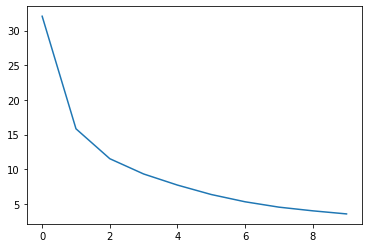

In [28]:
plt.plot(losses)

In [31]:
i = 2199

print(negative_tweets[i])
x=tweet_dataset.vocab.forward(process_tweet(negative_tweets[i]))
lens = torch.tensor([len(x)],dtype=torch.int64)
x = torch.tensor(x).unsqueeze(0)

net.eval()
torch.round(torch.sigmoid(net(x,lens))).item()

@Uber_Delhi no supercars &amp; now no ice cream in so many Gurgaon locations :-( pls add more locations!


0.0

# Sequence autoencoder with Twitter Sentiment Analysis Dataset
- uses stacked lstm as encoder and decoder
- takes the hidden state of the encoder and uses it as hidden state for each timestep at the decoder
- open questions
    - can MSELoss be used? (input and output are n-dimensional vectors)
    - if not what should the loss be